In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import cv2
import torch
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

In [2]:
if 0:
    import glob
    import joblib
    import os
    from PIL import Image
    import imagehash
    from tqdm.auto import tqdm

    paths = glob.glob('../input/petfinder-adoption-prediction/*/*jpg')

    result = joblib.Parallel(n_jobs=-1, verbose=1)(joblib.delayed(lambda x: imagehash.average_hash(Image.open(x)))(path) for path in paths)


    tmp = pd.DataFrame()
    tmp['path'] = paths
    tmp['hash'] = result
    tmp['hash'] = tmp['hash'].astype(str)

    tmp['is_train'] = tmp['path'].str.find('train') > -1
    tmp['is_test'] = tmp['path'].str.find('test') > -1
    tmp['idx'] = tmp['path'].map(lambda x: int(x.split('-')[-1][:-4]))
    tmp['PetID'] = tmp['path'].map(lambda x: x.split('/')[-1].split('-')[0])
    
    df1_train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
    df1_test = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')

    df1_train = pd.merge(tmp, df1_train, how='left', on='PetID')

    df1['is_train'] = df1['is_train'].astype(np.float32)
    df1['is_test'] = df1['is_train'].astype(np.float32)
    df1['hash'] = df1['hash'].astype(str)
    #df1 = df1[(df1['is_train'] > 0 ) | (~df1['hash'].isin(df1.loc[df1['is_train'] > 0, 'hash']))].reset_index(drop=True)
    df1.to_csv('df1_train_test.csv', index=False)

In [3]:
import os
from PIL import Image
import imagehash
from tqdm.auto import tqdm
if 0:
    df1 = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
    df1['path'] = '../input/petfinder-adoption-prediction/train_images/' + df1['PetID'] + '-1.jpg'
    df1 = df1[df1['path'].map(os.path.exists)]

    df2 = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
    df2['path'] = df2['Id'].map(lambda x:str(f'../input/petfinder-pawpularity-score/train/{x}.jpg'))

    df1['hash'] = [imagehash.average_hash(Image.open(x))
                        for x in tqdm(df1['path'].values)]
    df2['hash'] = [imagehash.average_hash(Image.open(x))
                        for x in tqdm(df2['path'].values)]
    #train_df_prev['hash'] = [imagehash.average_hash(Image.open(x))
    #                    for x in tqdm(train_df_prev['path'].values)]

    df1.to_csv('df1.csv', index=False)
    df2.to_csv('df2.csv', index=False)
else:
    df1 = pd.read_csv('../input/pet-data/df1_train_test.csv')
    df2 = pd.read_csv('../input/pet-data/df2.csv')

In [4]:
df1.T

,0,1,2,3,4,5,6,7,8,9,...,72766,72767,72768,72769,72770,72771,72772,72773,72774,72775
path,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,../input/petfinder-adoption-prediction/train_i...,...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...,../input/petfinder-adoption-prediction/test_im...
hash,193f20c0c86c2f2f,0f0f0f3fffffe000,387fef070743071f,0c00003f27e7ffff,ffb301d9f0e08e04,1f1f40602c1e9f9f,ffc7c3c7c3c3d3a7,fff860000083feff,18981c371fff0707,f0fcece060302040,...,0078784cecfdffff,78787c1c18797b38,0261f03cbaf1e87c,0f0f79f1f0f8f8b8,00000c1d9f8fffff,00003e3f3f1f0000,00001c1e6e7f767c,3070380cfbffffff,f000faffe7c3c111,78cf3c0d08e0e0fd
is_train,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_test,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
idx,2,4,4,22,3,6,1,2,1,6,...,2,10,4,3,1,1,6,6,2,2
PetID,d336e6953,77544cbd4,0149d04e7,cad25c91b,9c7476c25,e01f077a7,449290a8b,6c9382d17,ebdf19959,6a864757b,...,af7305535,f51767bbe,c46f3bb03,ef20ce351,8a69b8ca9,819610fb0,280dd2698,4b393cb28,b88cb23c9,311368756
Type,1,2,1,1,1,1,2,2,1,1,...,1,2,1,1,2,2,2,1,1,2
Name,Do-Re-Mi-Fa-So-La-Ti-Do,Cotton Candy Aka Putih,XiaoBai,Kikopup,Miss Brownie,Enzo,Tiger,Orion,Soya,Hachi,...,Mowgli.............,Boyz Trio,Rocky (Mixed Breed + Terrier),NaN,3 Little Cuties Ready To Be,Snowflake,"BimBam, Meow2",NaN,Mamma,"Dibo, Coco And Bimo"
Age,2,15,2,3,3,238,1,3,24,3,...,48,2,2,1,2,48,6,24,17,3
Breed1,26,266,307,307,307,307,299,299,72,307,...,307,266,307,307,266,280,289,307,307,266


In [5]:
df1.shape, df1.hash.nunique(), df2.hash.isin(df1.hash).sum()

((72776, 29), 70437, 1942)

In [6]:
#df1.to_csv('train_last_comp.csv', index=False)
df = pd.merge(df2, df1, how='left', on='hash')

In [7]:
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,2.0,1.0,4.0,0.0,41332.0,9fc95c2498ef8d6a31664ee13952224b,0.0,Puppies for adoption. Only for serious adopter...,6.0,3.0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,2.0,1.0,1.0,0.0,41326.0,50ad2daaae8196a6ca7de2fd0c2e7b7b,0.0,Didi is an orphan kitten found at the back of ...,2.0,1.0
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,2.0,1.0,1.0,0.0,41326.0,fa90fa5b1ee11c86938398b60abc32cb,0.0,Lovely puppy looking for a forever home. If u ...,3.0,2.0
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10015,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10016,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,2.0,1.0,1.0,0.0,41326.0,a042471e0f43f2cf707104a1a138a7df,0.0,Rescued as one of her siblings is inflected ma...,2.0,4.0


In [8]:
df['len_desc'] = df['Description'].fillna('').map(len)
df['len_word_desc'] = df['Description'].fillna('').map(lambda x: len(x.split()))
for n in ['No Name Yet']:#, 'No Name', 'Unknown']:
    df['Name'] = df['Name'].fillna('').replace(n, '')
df['len_name'] = df['Name'].map(len)
df['len_word_name'] = df['Name'].fillna('').map(lambda x: len(x.split()))

df['cnt_RescuerID'] = df['RescuerID'].map(df1['RescuerID'].value_counts())

In [9]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,10008,10009,10010,10011,10012,10013,10014,10015,10016,10017
Id,0007de18844b0dbbb5e1f607da0606e0,0009c66b9439883ba2750fb825e1d7db,0013fd999caf9a3efe1352ca1b0d937e,0018df346ac9c1d8413cfcc888ca8246,001dc955e10590d3ca4673f034feeef2,001dd4f6fafb890610b1635f967ea081,0023b8a3abc93c712edd6120867deb53,0031d6a9ef7340f898c3e05f92c7bb04,0042bc5bada6d1cf8951f8f9f0d399fa,0049cb81313c94fa007286e9039af910,...,ff78a56d5e0029cd6288c62f7b7f10e5,ff903858a9899465ee4cd17e942bef24,ff9b3b3468c4b35a3b6450a1ddc88449,ffaf7bf7e64b9eecaf02fc2c14d6b654,ffb8b466494a3e48bcb874a2fe9b976d,ffbfa0383c34dc513c95560d6e1fdb57,ffcc8532d76436fc79e50eb2e5238e45,ffdf2e8673a1da6fb80342fa3b119a20,fff19e2ce11718548fa1c5d039a5192a,fff8e47c766799c9e12f3cb3d66ad228
Subject Focus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Eyes,1,1,1,1,0,0,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Face,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Near,1,0,1,1,1,0,1,0,1,1,...,1,0,1,1,1,1,1,1,1,1
Action,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Accessory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Group,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Collage,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Human,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0


In [10]:
df2.columns

Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',
       'path', 'hash'],
      dtype='object')

In [11]:
df.columns

Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',
       'path_x', 'hash', 'path_y', 'is_train', 'is_test', 'idx', 'PetID',
       'Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PhotoAmt', 'AdoptionSpeed', 'len_desc',
       'len_word_desc', 'len_name', 'len_word_name', 'cnt_RescuerID'],
      dtype='object')

In [12]:
#df = pd.read_csv('../exps/exp1_swin_large_patch4_window12_384/train_cv_score.csv')
#df = pd.read_csv('ens_exp15.csv')

In [13]:
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed,len_desc,len_word_desc,len_name,len_word_name,cnt_RescuerID
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,9fc95c2498ef8d6a31664ee13952224b,0.0,Puppies for adoption. Only for serious adopter...,6.0,3.0,102,15,0,0,23.0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,50ad2daaae8196a6ca7de2fd0c2e7b7b,0.0,Didi is an orphan kitten found at the back of ...,2.0,1.0,601,113,4,1,5.0
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,fa90fa5b1ee11c86938398b60abc32cb,0.0,Lovely puppy looking for a forever home. If u ...,3.0,2.0,88,16,6,1,1640.0
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
10014,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
10015,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
10016,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,a042471e0f43f2cf707104a1a138a7df,0.0,Rescued as one of her siblings is inflected ma...,2.0,4.0,157,29,6,1,492.0


[0.50564147 0.18122343 0.31855626]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


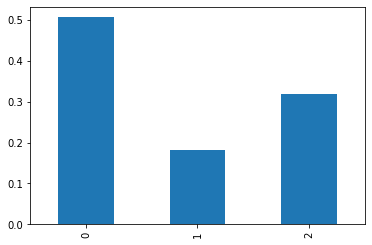

In [14]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')['Id'].map(lambda x:str(f'../input/petfinder-pawpularity-score/train/{x}.jpg'))
oof = pd.concat([train,
                 pd.read_csv('../input/petfinder-ensumble/exp085_ensumble/exp085_ensumble_oof.csv')['oof']], 
                 axis=1).set_index('Id')['oof']/100
oof2 = pd.concat([train,
                 pd.read_csv('../input/exp108/exp108_oof.csv')['pred']], 
                 axis=1).set_index('Id')['pred']/100


#df['pred4'] = df['path_x'].map(pd.read_csv('../input/pet-data/ens_exp15.csv', index_col='path')['pred'])
df['pred1'] = df['path_x'].map(pd.read_csv('../input/pet-data/ens_exp9.csv', index_col='path')['pred'])
df['pred2'] = df['path_x'].map(oof)
df['pred3'] = df['path_x'].map(oof2)

coef = np.linalg.lstsq(df[['pred1', 'pred2', 'pred3']], df['Pawpularity'] / 100)[0]
print(coef)
pd.Series(coef).plot(kind='bar')

df['pred'] = np.dot(df[['pred1', 'pred2', 'pred3']], coef)

#df['pred'] = df[['pred1', 'pred2', 'pred3', 'pred4']].values.mean(axis=1)
#df['pred']
#df[['pred1', 'pred2', 'pred3', 'pred4']]


In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

df['fold'] = -1


N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=5, random_state=365, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(df.index, df['Pawpularity'])):
    df.loc[train_index, 'fold'] = i

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [16]:
COL_FEATURES = ['Blur', 
                #'Face', 
                #'Occlusion',
                'Eyes',
                #'Accessory',
               #'Group',
                #'Human',
                #'Near',
                #'Collage',
                #'Info',# 
                #'Action',
                
                'pred',
                #'pred1', 'pred2', 'pred3', 'pred4',
                
                'len_desc', 'len_name', 
                #'len_word_desc', 'len_word_name',
                #'isin'
                #'breed_label', 'breed_prob',
                #'img_h', 'img_w',
                #'det_label', 'det_left', 'det_top', 'det_right', 'det_bottom', 'det_prob'
               ] + df1.drop(['Name', 'RescuerID', 'Description', 'PetID', 'path', 'hash',
                             'Type', 'VideoAmt', 'Sterilized', 'MaturitySize', 'Health', 'Dewormed',
                             'idx'
                            ], axis=1).columns.tolist()

COL_FEATURES += breed_pred_feature_columns
#COL_FEATURES = COL_FEATURES[:7]

NameError: name 'breed_pred_feature_columns' is not defined

In [ ]:
def rmse(preds, train_data):
    labels = train_data.get_label()
    #import pdb;pdb.set_trace()
    loss = np.sqrt(((labels - preds.clip(0.01, 1)) ** 2).mean()) * 100
    
    #loss = np.sqrt(((labels - preds.reshape(-1, 100).argmax(axis=1)) ** 2).mean())
    return 'rmse', loss, False


def train(fold, param):
     
    X_train = df.loc[df['fold'] != fold, COL_FEATURES]
    y_train = df.loc[df['fold'] != fold, 'Pawpularity'].values  / 100
    
    X_valid = df.loc[df['fold'] == fold, COL_FEATURES]
    y_valid = df.loc[df['fold'] == fold, 'Pawpularity'].values  / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      #early_stopping_rounds=50,
                      verbose_eval=100,
                      feval=rmse
                      )
    return model

def train_all(param):
     
    X_train = df.loc[:, COL_FEATURES]
    y_train = df.loc[:, 'Pawpularity'].values  / 100
    
    X_valid = df.loc[:, COL_FEATURES]
    y_valid = df.loc[:, 'Pawpularity'].values  / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      early_stopping_rounds=50,
                      verbose_eval=100,
                      feval=rmse
                      )
    return model

In [ ]:
if 0: 
    all_params = {'objective': ['tweedie', 'mse', 'xentropy'],
                  'tweedie_variance_power': [1.2],
                 'verbosity': [-1],
                 'boosting_type': ['gbdt'],
                 'feature_pre_filter': [False],
                 #'bagging_fraction': [0.7, 0.8, 0.9, 1, 0.95],
                 'bagging_freq': [1],
                 'num_iterations': [10000],
                 'early_stopping_round': [100],
                 'n_jobs': [16],
                 'seed': [114],
                 'metric':  ['None'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
                 'learning_rate': [0.05],
                  'lambda_l1': [0],
                  'lambda_l2': [1],
                  'min_child_samples': [150, 140, 160],
                  'num_leaves': [7, 15, 31],
                  'feature_fraction': [0.8, 0.9, 0.7],
                  'min_gain_to_split': [0.02, 0.01],
                  'linear_tree': [False],
                  #'max_bins': [8, 16, 32, 62, 128, 256, 512]
                 }
else:
    all_params = {'objective': ['tweedie'],
                  'tweedie_variance_power': [1.2],
                 'verbosity': [-1],
                 'boosting_type': ['gbdt'],
                 'feature_pre_filter': [False],
                 #'bagging_fraction': [0.7, 0.8, 0.9, 1, 0.95],
                 'bagging_freq': [1],
                 'num_iterations': [10000],
                 'early_stopping_round': [100],
                 'n_jobs': [16],
                 'seed': [114],
                 'metric':  ['None'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
                 'learning_rate': [0.05],
                  'lambda_l1': [0],
                  'lambda_l2': [1],
                  'min_child_samples': [140],
                  'num_leaves': [7],
                  'feature_fraction': [0.9],
                  'min_gain_to_split': [0.01],
                  'linear_tree': [False],
                  #'max_bins': [8, 16, 32, 62, 128, 256, 512]
                 }

In [ ]:
best_score = 1.0e10
best_param = None
for param in tqdm(ParameterGrid(all_params)):
    print(param)
    list_loss = []
    list_imp = []
    list_num = []
    for fold in range(5):
        model = train(fold, param)
        sc = model.best_score['valid_0']['rmse']# * 100
        list_loss.append(sc)
        list_num.append(model.best_iteration)
        
        imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
        imp['col'] = COL_FEATURES
        list_imp.append(imp.set_index('col'))
    sc = np.mean(list_loss)
    if sc < best_score:
        best_score = sc
        best_param = param

In [ ]:
17.122953793907463
17.12237161917507
17.12206798235878
17.035855591812624
17.012832654542915
17.007733147459998
16.97424681479059

16.999355490956553
16.98202345664681
16.97124025234951

print(best_param)
print(best_score)

In [ ]:
best_param['num_iterations'] = round(np.mean(list_num) * 1.1)

In [ ]:
model = train_all(best_param)

In [ ]:
aaa = 0
for i in range(5):
    aaa += np.sqrt(((df.loc[df['fold']==i, 'pred'] * 100 - df.loc[df['fold']==i, 'Pawpularity']) ** 2).mean())
aaa / 5

In [ ]:
with open('model_lgb_last_comp_all.pkl', 'wb') as f:
    pickle.dump(model, f, -1)

In [ ]:
#imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
#imp['col'] = COL_FEATURES
imp = sum(list_imp) / 5
imp.sort_values('imp', ascending=False)

In [ ]:
model.feature_name()